In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import *
import datetime

def days_between(d1, d2):
    d1 = d1.strftime("%Y-%m-%d")
    d2 = d2.strftime("%Y-%m-%d")
    return abs((d2 - d1).days)

cols1 = ['country','age','date_hospitalised','date_death','date_recovered','date_onset','date_first_consultation']
cols2 = ['sex','birth_year','country','group','infection_reason','exposure_start','confirmed_date','released_date','deceased_date']
cols3 = ['Age','Gender','Nationality','Symptomatic ToConfirmation','Days ToRecover']
cols1_rename = ['country','age','hospit_date','death_date','rec_date','onset_date','confirm_date']
cols2_rename = ['sex','birth_year','country', 'group','infection_reason','exposure_start','confirm_date','releas_date','decease_date']
cols3_rename = ['age', 'sex', 'country', 'sympt_to_confirm', 'confirm_to_release']

data1 = pd.read_csv(r"data/subset_international_cases_2020_03_11.csv", usecols=cols1)
data2 = pd.read_csv(r"data/patients.csv", usecols=cols2)
data3 = pd.read_csv(r"data/data (30).csv", usecols=cols3)

data1 = data1.rename(columns={k:v for k,v in zip(cols1,cols1_rename)})
data2 = data2.rename(columns={k:v for k,v in zip(cols2,cols2_rename)})
data3 = data3.rename(columns={k:v for k,v in zip(cols3,cols3_rename)})
cols1 = cols1_rename
cols2 = cols2_rename
cols3 = cols3_rename

# data 1
for col in cols1[2:]:
    data1[col] = pd.to_datetime(data1[col], format='%d/%m/%Y')
    
data1['onset_to_confirm'] = (data1['confirm_date']-data1['onset_date']).dt.days
data1['hospit_to_decease'] = (data1['death_date']-data1['hospit_date']).dt.days
data1['hospit_to_release'] = (data1['rec_date']-data1['hospit_date']).dt.days
data1 = data1.drop(columns=['hospit_date', 'death_date', 'rec_date', 'onset_date', 'confirm_date'])
data1.loc[data1['hospit_to_decease'].notna()]

# data 2
data2['age'] = 2020 - data2['birth_year']
for col in cols2[5:]:
    data2[col] = pd.to_datetime(data2[col])
data2['expose_to_confirm'] = (data2['confirm_date']-data2['exposure_start']).dt.days
data2['confirm_to_release'] = (data2['releas_date']-data2['confirm_date']).dt.days
data2['confirm_to_decease'] = (data2['decease_date']-data2['confirm_date']).dt.days
data2 = data2.drop(columns=['birth_year', 'exposure_start', 'confirm_date', 'confirm_date', 'releas_date', 'decease_date'])
data2 = data2.loc[data2['country'] == 'Korea']
data2 = data2.replace('Korea', 'South Korea')
data2 = data2.loc[data2['group'] != 'Shincheonji Church']
data2 = data2.loc[data2['infection_reason'] != 'contact with patient']
# data2 = data2.loc[data2['expose_to_confirm'] == 0]

# data 3
data3 = data3.loc[data3['country'] == 'Taiwanese']  # in Taiwan: confirm = hospital
data3 = data3.replace('Taiwanese', 'Taiwan')
data3['sex'] = data3['sex'].str.lower()

print(data1['country'].unique())
print(data2['country'].unique())
print(data3['country'].unique())


data1 = data1.loc[data1['onset_to_confirm'].notna()]      # 173 cases
# data1 = data1.loc[data1['hospit_to_release'].notna()]     # 51 cases
# data1 = data1.loc[data1['hospit_to_decease'].notna()]     # only 6 cases

data2 = data2.loc[data2['expose_to_confirm'].notna()]     # 352 cases
# data2 = data2.loc[data2['confirm_to_release'].notna()]    # 50 cases   # in Taiwan: confirm = hospital
# data2 = data2.loc[data2['confirm_to_decease'].notna()]    # 35 cases

data3 = data3.loc[data3['sympt_to_confirm'].notna()]      # 275 cases
# data3 = data3.loc[data3['confirm_to_release'].notna()]    # only 9 cases  # otherwise isolated

data2 = data2.loc[data2['expose_to_confirm'] >= 0]

['Japan' 'Singapore' 'South Korea' 'HK SAR']
['South Korea']
['Taiwan']


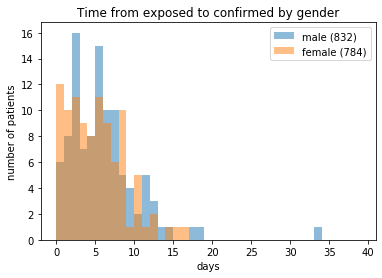

In [21]:
male = data2.loc[data2['sex'] == 'male']
female = data2.loc[data2['sex'] == 'female']

plt.title('Time from exposed to confirmed')
plt.xlabel('days')
plt.ylabel('number of patients')

for gender, label in zip([male, female], ['male', 'female']):
    plt.hist(gender['expose_to_confirm'], bins=np.arange(0,40,1), alpha=0.5, label=label+' ('+str(len(gender))+')')

plt.legend()

plt.title('Time from exposed to confirmed by gender')
plt.xlabel('days')
plt.ylabel('number of patients')
plt.savefig('figures/exp_to_conf-genders.png')

(0, 25) (0.306843973910365, -7.430108502154311e-11, 4.795927652162714)
(25, 40) (0.9738018186488739, -4.021199660181376e-09, 3.9018633176986475)
(40, 60) (0.0004395679042867068, -8.669053066435463e-10, 8.109648499528081)
(60, 70) (0.35816258456795214, -2.383036624174077e-10, 6.036896545892683)
(70, 200) (1.2762087284977537, 0.9999999968288857, 4.09124207202561)


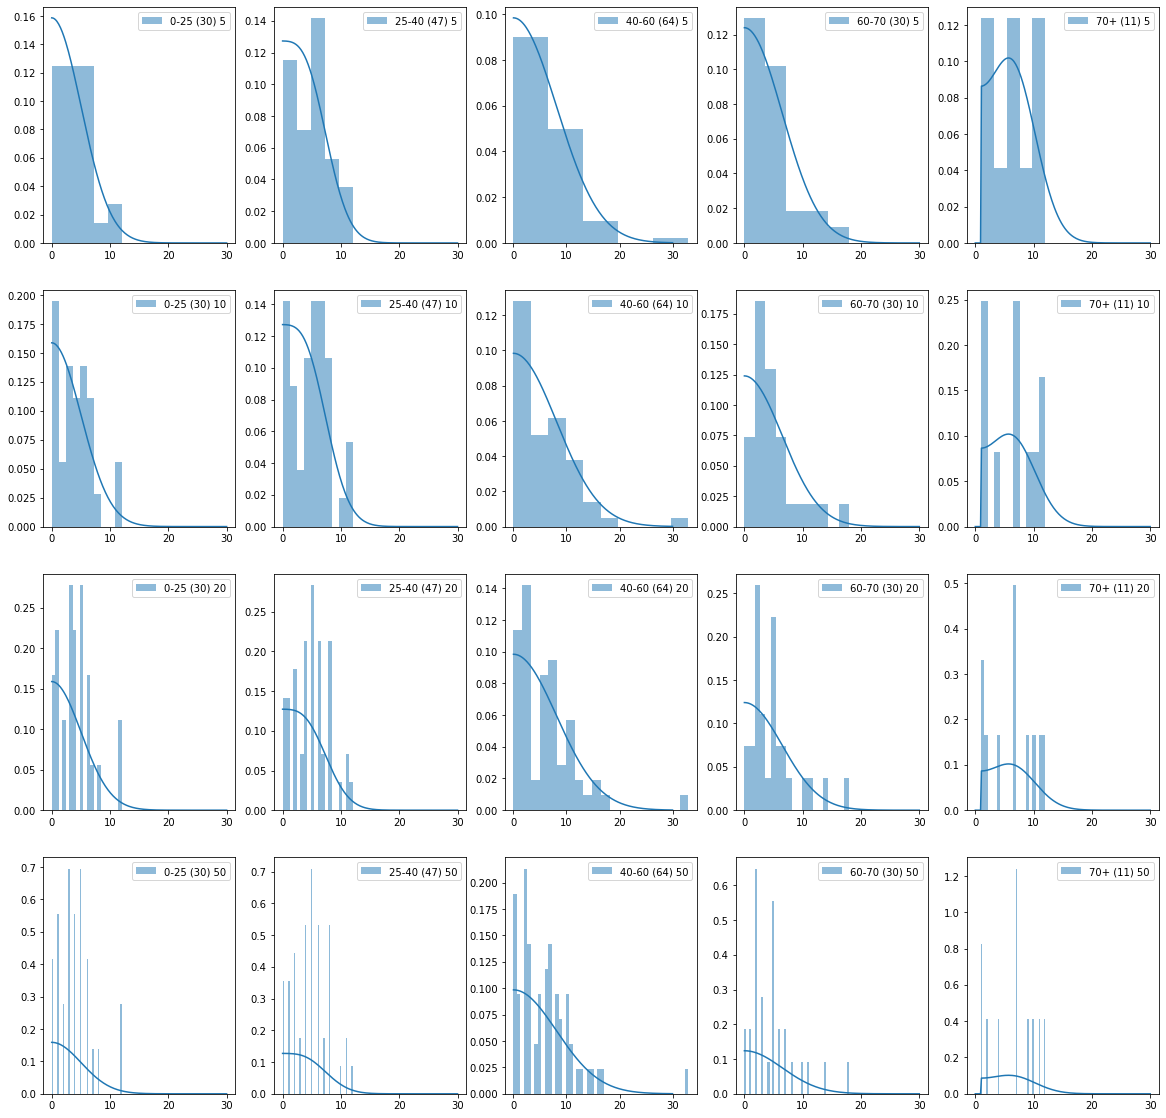

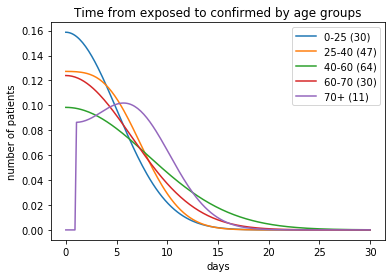

In [251]:
from statistics_module import *
from ages_module import parse_age_groups_i
from scipy.optimize import minimize

dist = foldnorm
x0 = [0.5,2.,1]
x = np.linspace(0, 30, 200)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# age_groups = [(0,10),(10,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,200)]
age_groups = [(0,25),(25,40),(40,60),(60,70),(70,200)]

data_age_groups = []
age_groups_moments = []
for age_group in age_groups:
    this_age_group = data2['expose_to_confirm'].loc[(data2['age'] > age_group[0]) & (data2['age'] < age_group[1])]
    data_age_groups.append(this_age_group)
    mean, median, std, p5, p95 = this_age_group.mean(), this_age_group.median(), this_age_group.std(), this_age_group.quantile(.05), this_age_group.quantile(.95)
    # print(age_group, this_age_group.size, mean, median, std, p5, p95)
    # age_groups_moments.append(minimize(generate_lms_function(dist, mean=mean,median=median,std=std,loc=True),x0).x)
    params = dist.fit(this_age_group)
    print(age_group, params)
    age_groups_moments.append(params)

fig, axarr = plt.subplots(4,5, figsize=(20,20))

data_groups = np.array(data_age_groups)
data_age_groups_labels = parse_age_groups_i(age_groups)
for i, label in enumerate(data_age_groups_labels):
    data_age_groups_labels[i] = label+' ('+str(len(data_groups[i]))+')'
    for j, bins in enumerate([5,10,20,50]):
        axarr[j,i].hist(data_groups[i], bins=bins, label=data_age_groups_labels[i]+' '+str(bins), density=True, alpha=0.5)
        axarr[j,i].legend()
for i, (params, color) in enumerate(zip(age_groups_moments[:], colors[:])):
    axarr[0,i].plot(x, dist.pdf(x, *params), color=colors[0])
    axarr[1,i].plot(x, dist.pdf(x, *params), color=colors[0])
    axarr[2,i].plot(x, dist.pdf(x, *params), color=colors[0])
    axarr[3,i].plot(x, dist.pdf(x, *params), color=colors[0])

plt.savefig('figures/exp_to_conf-agegroups.png')

plt.figure()
for i, (params, color) in enumerate(zip(age_groups_moments[:], colors[:])):
    plt.plot(x, dist.pdf(x, *params), color=color, label=data_age_groups_labels[i])

plt.legend()
plt.title('Time from exposed to confirmed by age groups')
plt.xlabel('days')
plt.ylabel('number of patients')
plt.savefig('figures/exp_to_conf-agegroups-fit.png')

[0.6233333333333331, 0.376666666666667] 1.0
1.336583890315159 10.41166351022897 loc=0  |prob= 0.6233333333333331
1.7043779472484368 8.393791356409668 loc=0  |prob= 0.376666666666667


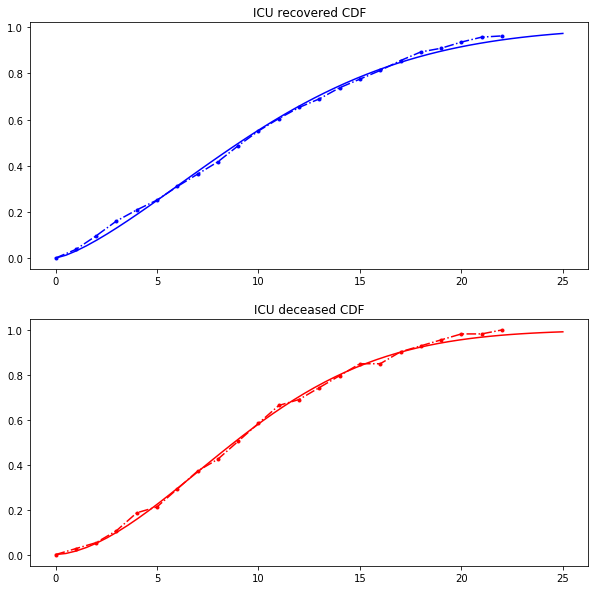

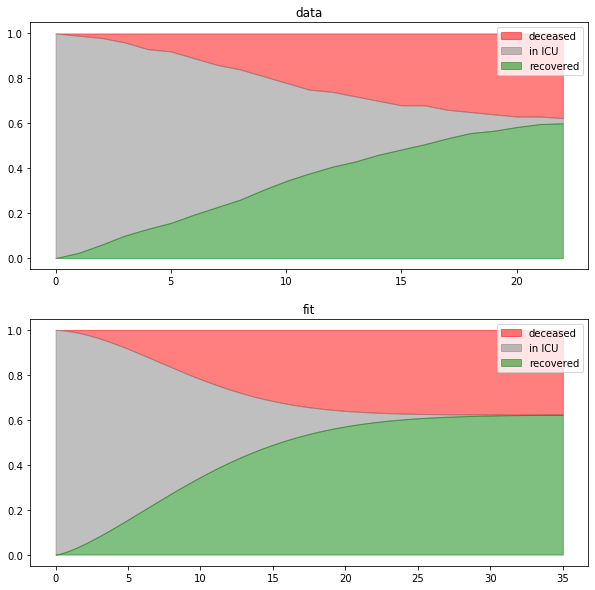

In [184]:
data4 = pd.read_csv(r"data/survival_ICU_2.csv")
data4 = data4.rename(columns={k:v for k,v in zip(['day', 'percent recovered', 'percent died'],['day','rec','die'])})
data4 = data4.loc[:, ['rec','die']] / 100
days = np.arange(0, len(data4))

# plt.plot(days, data4['rec'], '.-', color='b')
# plt.plot(days, 1-data4['die'], '.-', color='r')

# plt.fill_between(days, 1-data4['die'], np.ones_like(data4['die']), color='r', alpha=0.5, label='deceased')
# plt.fill_between(days, data4['rec'], 1-data4['die'], color='grey', alpha=0.5, label='in ICU')
# plt.fill_between(days, np.zeros_like(data4['rec']), data4['rec'], color='g', alpha=0.5, label='recovered')
# 
# plt.legend()
# plt.xlabel('day')
# plt.ylabel('fraction of ICU patients')
# plt.title('ICU - recovered/deceased')

cdf_die = np.array(data4['die'])
cdf_rec = np.array((data4['rec']))
tot_prob = [cdf_rec[-1], cdf_die[-1]]
tot_prob = [1-cdf_die[-1], cdf_die[-1]]
print(tot_prob, sum(tot_prob))
cdf_rec /= tot_prob[0]
cdf_die /= tot_prob[1]
save_params=[]
fig, ax = plt.subplots(2, figsize=(10,10))
for i, (data, c) in enumerate(zip([cdf_rec, cdf_die], ['b', 'r'])):
    # x = np.linspace(0,22,100)
    f = lambda x,mu,sigma: chi(mu,loc=0,scale=sigma).cdf(x)
    mu,sigma = curve_fit(f,days,data)[0]
    
    ax[i].plot(days, data, '.-.', color=c)
    # ax[i].plot(days, cdf_die)
    x=np.linspace(0,25)
    ax[i].plot(x, chi(mu,loc=0,scale=sigma).cdf(x),color=c)
    # plt.plot(days, norm(mu,sigma).cdf(day))
    print(mu,sigma,'loc=0', ' |prob=',tot_prob[i])
    save_params.append([mu,sigma])
ax[0].set_title('ICU recovered CDF')
ax[1].set_title('ICU deceased CDF')
# plt.plot(days,y)
# plt.plot(days,np.gradient(data4['die']))
plt.savefig('figures/ICU_CDF.png')

fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].fill_between(days, 1-data4['die'], np.ones_like(data4['die']), color='r', alpha=0.5, label='deceased')
ax[0].fill_between(days, data4['rec'], 1-data4['die'], color='grey', alpha=0.5, label='in ICU')
ax[0].fill_between(days, np.zeros_like(data4['rec']), data4['rec'], color='g', alpha=0.5, label='recovered')

x = np.linspace(0,7*5,200)
ax[1].fill_between(x, 1-chi(save_params[1][0],loc=0,scale=save_params[1][1]).cdf(x)*tot_prob[1], np.ones_like(x), color='r', alpha=0.5, label='deceased')
ax[1].fill_between(x, chi(save_params[0][0],loc=0,scale=save_params[0][1]).cdf(x)*tot_prob[0],
                   1-chi(save_params[1][0],loc=0,scale=save_params[1][1]).cdf(x)*tot_prob[1], color='grey', alpha=0.5, label='in ICU')
ax[1].fill_between(x, np.zeros_like(x), chi(save_params[0][0],loc=0,scale=save_params[0][1]).cdf(x)*tot_prob[0],
                   color='g', alpha=0.5, label='recovered')

ax[0].legend()
ax[1].legend()
ax[0].set_title('data')
ax[1].set_title('fit')
plt.savefig('figures/ICU_CDF2.png')

62      89
72      80
73      53
0       30
1       47
        ..
8143    55
8172     1
8177    52
8178    41
8184    20
Name: age, Length: 397, dtype: int32
(0, 25) (6.862405121777224, 0, 0.6654599960770596)
(25, 40) (4.600731057011496, 0, 1.2797668070073258)
(40, 60) (5.140080507620876, 0, 1.18474829693502)
(60, 70) (4.618922833099324, 0, 1.5845976836595266)
(70, 200) (5.647557704994501, 0, 1.0199124496408762)


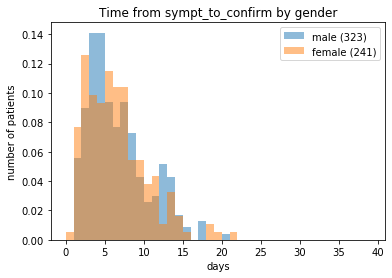

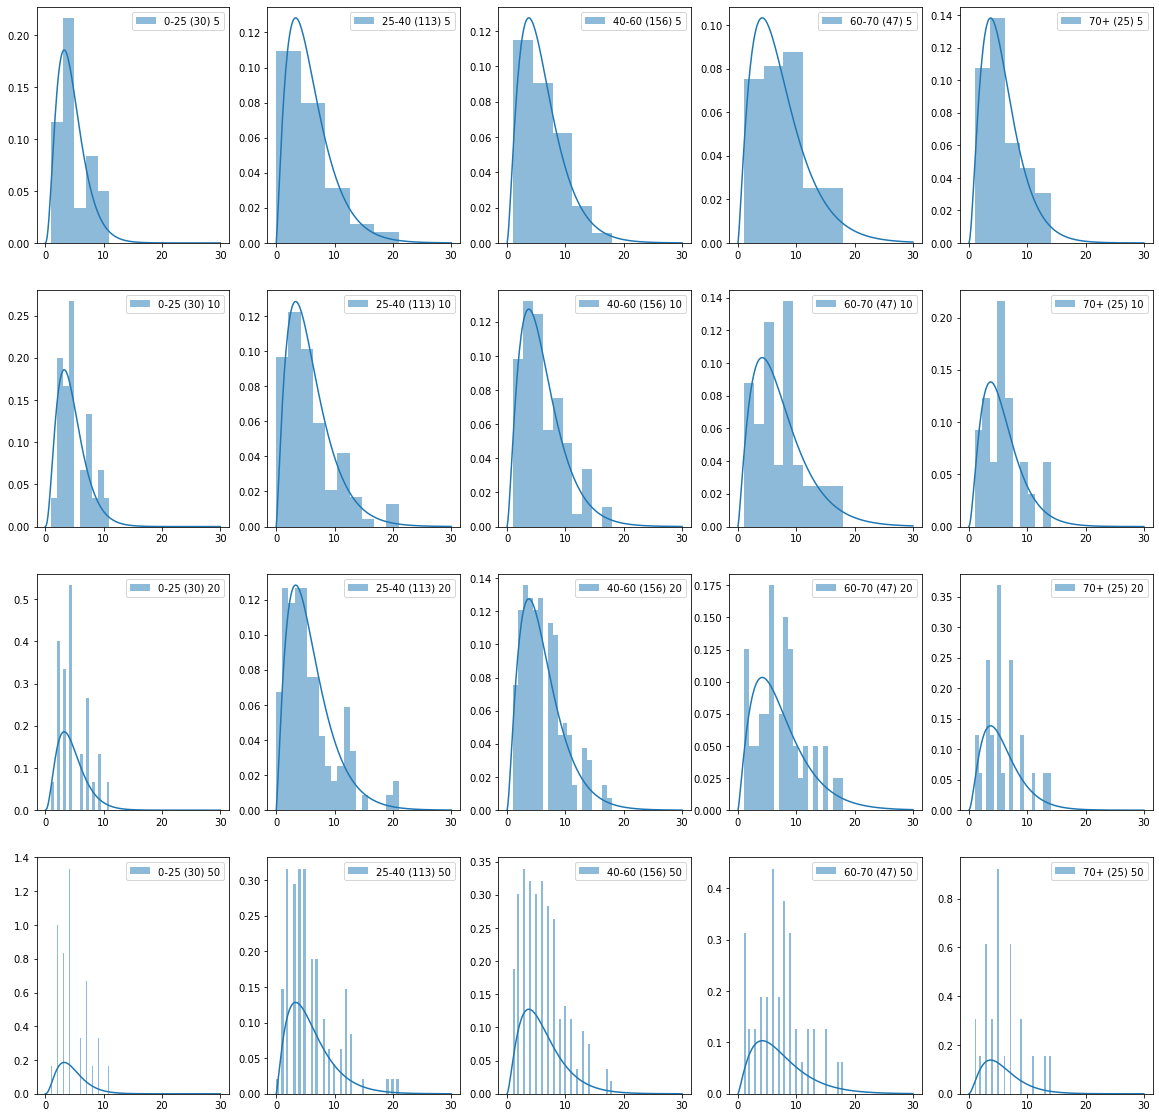

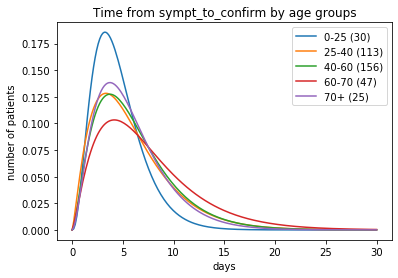

In [42]:
cols5 = ['age','sex','outcome','date_onset_symptoms','date_admission_hospital','date_confirmation','date_death_or_discharge']
cols6 = ['age','sex','outcome','date_onset_symptoms','date_admission_hospital','date_confirmation','date_death_or_discharge']

data5 = pd.read_csv(r"data/clean-hubei.csv", usecols=cols5)
data6 = pd.read_csv(r"data/clean-outside-hubei.csv", usecols=cols6)
# data5 = data5.rename(columns={k:v for k,v in zip(cols5, cols5_rename)})
# data6 = data6.rename(columns={k:v for k,v in zip(cols6, cols6_rename)})

data5 = data5.loc[~((data5['date_onset_symptoms'].isna() & data5['date_onset_symptoms']!='- 18.01.2020') & data5['date_admission_hospital'].isna() & data5['date_death_or_discharge'].isna())]
data6 = data6.loc[~((data6['date_onset_symptoms'].isna() & data6['date_onset_symptoms']!='- 18.01.2020') & data6['date_admission_hospital'].isna() & data6['date_death_or_discharge'].isna())]
data5 = pd.concat([data5, data6])

#data5
for col in cols5[3:]:
    data5[col] = pd.to_datetime(data5[col], format='%d.%m.%Y')

data5['sympt_to_hospit'] = (data5['date_admission_hospital']-data5['date_onset_symptoms']).dt.days
data5['sympt_to_confirm'] = (data5['date_confirmation']-data5['date_onset_symptoms']).dt.days
rec = data5.loc[data5['outcome'] == 'discharged'].copy()
die = data5.loc[data5['outcome'] == 'died'].copy()
rec['hospit_to_release'] = (rec['date_death_or_discharge']-rec['date_admission_hospital']).dt.days
die['hospit_to_decease'] = (die['date_death_or_discharge']-die['date_admission_hospital']).dt.days
# data5 = data5.drop(columns=['hospit_date', 'death_date', 'rec_date', 'onset_date', 'confirm_date'])
# data5.loc[data5['hospit_to_decease'].notna()]

# data5 = data5.loc[data5['sympt_to_hospit'].notna()]       # 451 cases
# data5 = data5.loc[data5['sympt_to_confirm'].notna()]      # 420 cases
# data5 = rec.loc[rec['hospit_to_release'].notna()]         # 23 cases
# data5 = die.loc[die['hospit_to_decease'].notna()]         # 37 cases

look = 'sympt_to_confirm'

male = data5.loc[data5['sex'] == 'male']
female = data5.loc[data5['sex'] == 'female']

plt.title('Time from exposed to confirmed')
plt.xlabel('days')
plt.ylabel('number of patients')

for gender, label in zip([male, female], ['male', 'female']):
    plt.hist(gender[look], bins=np.arange(0,40,1), density=True, alpha=0.5, label=label+' ('+str(len(gender))+')')

plt.legend()

plt.title('Time from '+look+' by gender')
plt.xlabel('days')
plt.ylabel('number of patients')
plt.savefig('figures/'+look+'-genders.png')


from statistics_module import *
from ages_module import parse_age_groups_i
from scipy.optimize import minimize

dist = chi2
x0 = [0.5,2.,1]
x = np.linspace(0, 30, 200)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# age_groups = [(0,10),(10,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,200)]
age_groups = [(0,25),(25,40),(40,60),(60,70),(70,200)]
# age_groups = [(0,25),(25,40),(40,60)]
# age_groups = [(40,60),(60,70),(70,200)]

data_age_groups = []
age_groups_moments = []

data5 = data5.loc[data5['age'].notna()]
data5 = data5.loc[data5['age'].str.isnumeric()]
data5 = data5[data5[look].notna()]
data5['age']=data5['age'].astype(int)
print(data5['age'])
for age_group in age_groups:
    this_age_group = data5[look].loc[(data5['age'] > age_group[0]) & (data5['age'] < age_group[1])]
    data_age_groups.append(this_age_group)
    mean, median, std, p5, p95 = this_age_group.mean(), this_age_group.median(), this_age_group.std(), this_age_group.quantile(.05), this_age_group.quantile(.95)
    params = dist.fit(this_age_group,floc=0)
    # f = lambda x, mu, sigma: dist(mu,sigma).cdf(x)
    # params = curve_fit(f, days, cdf_rec)[0]
    print(age_group, params)
    age_groups_moments.append(params)

fig, axarr = plt.subplots(4,5, figsize=(20,20))

data_groups = np.array(data_age_groups)
data_age_groups_labels = parse_age_groups_i(age_groups)
for i, label in enumerate(data_age_groups_labels):
    data_age_groups_labels[i] = label+' ('+str(len(data_groups[i]))+')'
    for j, bins in enumerate([5,10,20,50]):
        axarr[j,i].hist(data_groups[i], bins=bins, label=data_age_groups_labels[i]+' '+str(bins), density=True, alpha=0.5)
        axarr[j,i].legend()
for i, (params, color) in enumerate(zip(age_groups_moments[:], colors[:])):
    axarr[0,i].plot(x, dist.pdf(x, *params), color=colors[0])
    axarr[1,i].plot(x, dist.pdf(x, *params), color=colors[0])
    axarr[2,i].plot(x, dist.pdf(x, *params), color=colors[0])
    axarr[3,i].plot(x, dist.pdf(x, *params), color=colors[0])

plt.savefig('figures/'+look+'-agegroups.png')

plt.figure()
for i, (params, color) in enumerate(zip(age_groups_moments[:], colors[:])):
    plt.plot(x, dist.pdf(x, *params), color=color, label=data_age_groups_labels[i])

plt.legend()
plt.title('Time from '+look+' by age groups')
plt.xlabel('days')
plt.ylabel('number of patients')
plt.savefig('figures/'+look+'-agegroups-fit.png')
